## **To recreate study results please load package versions found in main_requirements.txt**

In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# less common imports
import matplotlib.image as mpimg
from pygam import LinearGAM, GAM, s, l
from sklearn import preprocessing
from scipy import stats
from scipy import spatial
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import shutil
import gc
from seaborn import clustermap
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 pynndescent==0.5.8


In [19]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [20]:
#v_colors = ['#ffc857', '#c6d5c0', '#558140', '#6e0614', '#8b3843', '#a86a72',
#       '#c59ba1', '#8eab80', '#ecd1c8', '#484848', '#92afc2', '#255f85',
#       '#e2cdd0', '#c77459', '#daa290', '#ffffff', '#b44622', '#1c5701',
#       '#a3a3a3',
#        'red', 'yellow', 'lime']
v_colors = ['#ffc857', '#c6d5c0', '#558140', '#6e0614', '#8b3843', 
            '#a86a72', '#c59ba1', '#8eab80', '#ecd1c8', '#484848', 
            '#92afc2', '#255f85', '#e2cdd0', '#c77459', '#daa290', 
            'fuchsia', '#b44622', '#1c5701', '#a3a3a3',
            'red', 'yellow', 'lime' ]

## **Format logTMM data from limma-voom into workable form for GAM curve fitting**

In [18]:
# Set path and read in logTMM normalized data from limma-voom output directories
# These directories can be downloaded from http://brain.listerlab.org/Major-Traj-Limma-Voom.html
# dt_path = "../data/limma-voom/"
# dt_fls = os.listdir( path=dt_path)

In [4]:
# read in anndata for obs
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.excitatory_select.h5ad")
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.inhibitory_select.h5ad")
adata = sc.read_h5ad("data/2023-05-16_input/seurat.merged.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
# obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

In [21]:
# load log2 TMM pseudo-bulked data from limma-voom
# logTMMs.pkl was saved in 11__dev-DEGs_age-trend-fits_rate-of-change.ipynb
logTMMs = nmc.load_obj("data/dev_deg_v8/logTMMs.pkl")

In [6]:
# example logTMM dataframe
logTMMs['i-M8'].head()

,i.M8..p10f_mar23,i.M8..p10m,i.M8..p10m_apr23,i.M8..p18f_oct,i.M8..p18m_oct,i.M8..p28f,i.M8..p4f_oct,i.M8..p65f_apr23,i.M8..p65f_april
Kcnb2,10.029761,9.920135,10.105796,9.965136,9.885480,9.605430,10.142428,9.758785,9.660595
Rims1,9.952696,10.052079,10.116816,10.114383,10.200507,10.161677,10.077906,9.928152,9.885925
Adgrb3,10.623404,10.482754,10.587248,10.474635,10.412548,10.387972,10.498340,10.296733,10.280345
Tmeff2,9.337909,9.180874,9.438520,9.268024,8.735979,8.832013,9.050884,8.628403,8.805092
Gls,9.722378,9.507182,9.565877,9.423002,9.532491,9.578070,9.846138,9.420894,9.199894


In [22]:
obs_df['batch'] = "X" + obs_df['my.cell.type'].astype(str)+".."+obs_df['sample'].astype(str) 
obs_df['batch']

e16f_AAACCAACAGGTCCTG-1                Xe-L4..e16f
e16f_AAACGGATCAATTACG-1                Xe-B1..e16f
e16f_AAACGGATCCACCTGT-1                Xe-N8..e16f
e16f_AAACGGATCGTTACTT-1                Xe-N3..e16f
e16f_AAACGGATCTATTGTC-1                Xe-B1..e16f
                                       ...        
apr23_p65f_TTAGGCCCACAATACT-1    Xi-H6..p65f_apr23
apr23_p65f_TTCACTGTCTGGTCCT-1    Xi-L6..p65f_apr23
apr23_p65f_TTTGCGACACCTCACC-1    Xi-H6..p65f_apr23
apr23_p65f_TTTGGTGCATCAGTAT-1    Xi-H6..p65f_apr23
apr23_p65f_TTTGTGAAGATGGAGC-1    Xi-H6..p65f_apr23
Name: batch, Length: 150180, dtype: object

In [23]:
# make numerical age, gestation - 20 days, embryonic = value, post-natal = +20
# create numerical age -day-wise
# here parse only first part of the sample
key_itr = "i-B1"
sig_df = logTMMs[key_itr]
ax_age = [s.split("..")[1].split("_")[0] for s in sig_df.columns]
#ax_age
ai_age = []
# only for samples which are part of pseudobulk
sample_age = {}
for age in ax_age:
    i_age = 0
    if age[0] == "e":
        i_age = int(age[1:3])
    elif age[0:2] == "p0":
        i_age = 20
    elif age[0:2] == "p4":
        i_age = 24
    else:
        i_age = int(age[1:3]) + 20
    ai_age.append(i_age)
    sample_age[age] = i_age
print(sample_age)

{'e16f': 16, 'e16m': 16, 'e18f': 18, 'e18m': 18, 'p0f': 20, 'p0f2': 20, 'p0m': 20, 'p10f': 30, 'p10m': 30, 'p18f': 38, 'p18m': 38, 'p28f': 48, 'p28m': 48, 'p4f': 24, 'p4m': 24, 'p65f': 85, 'p65m': 85}


In [11]:
# change column names in each logTMM to stage of batch
# will use these values as x-axis in curve fitting
# yes column names may repeat
# plot_labels = {}
#for key_itr in logTMMs.keys():
#    new_cols = []
#    for col_itr in logTMMs[key_itr]:
#        # age_itr = obs_df['age'][obs_df['batch']==col_itr].values[0]
#        sample = col_itr.split("..")[1].split("_")[0]
#        age_itr = sample_age[sample]
#        new_cols.append( age_itr)        
#    plot_labels[key_itr] = [ii.split('..')[1].split("_")[0] for ii in logTMMs[key_itr].columns]
#    logTMMs[key_itr].columns = new_cols

In [25]:
logTMMs['i-B1'].head()

,i.B1..e16f,i.B1..e16m_apr23,i.B1..e18f,i.B1..e18f_may22,i.B1..e18m,i.B1..e18m_may22,i.B1..p0f,i.B1..p0f2,i.B1..p0m_july,i.B1..p10f,...,i.B1..p28m,i.B1..p28m_may22,i.B1..p4f,i.B1..p4f_oct,i.B1..p4m,i.B1..p4m_mar23,i.B1..p65f_apr23,i.B1..p65f_april,i.B1..p65m_april,i.B1..p65m_aug
Xkr4,9.875470,9.776237,9.691923,9.430306,9.819623,9.697179,9.575713,9.693702,9.804442,9.333805,...,9.608604,9.487149,9.576840,9.958170,9.629906,9.621502,9.521372,9.517490,9.338353,9.522297
Gm1992,5.851207,5.232553,6.053854,5.826121,5.776116,5.458429,5.512119,6.108162,5.032528,5.401497,...,5.577309,5.609402,6.163097,6.171596,5.834913,5.429569,6.393374,6.384795,5.744048,6.369843
Lypla1,4.648846,4.656496,4.351695,4.269053,3.992352,3.011423,4.676092,4.772100,5.182934,5.130299,...,5.938865,4.707842,3.981086,3.803717,4.712179,5.054644,5.429095,5.926005,5.931286,6.200492
Rgs20,5.023683,5.472803,5.042344,5.925932,5.542831,4.289349,5.791760,5.008681,5.328304,6.122667,...,6.394703,5.658588,5.835180,6.454729,5.651231,4.148809,6.777269,6.003072,5.956459,6.268452
Oprk1,3.914384,3.921607,4.835120,3.011423,3.011423,4.666420,4.531199,3.576861,4.380674,5.698643,...,4.987348,6.124663,4.500035,4.982421,5.409256,3.011423,5.769054,4.672944,6.055941,6.575318


## **Fit GAM to each gene across stages**

In [24]:
cluster = "i-B1"
scat_df = logTMMs[cluster]
ai_age = []
sample_age = {}
for batch in scat_df.columns:
    age = batch.split("..")[1].split("_")[0]
    i_age = 0
    if age[0] == "e":
        i_age = int(age[1:3])
    elif age[0:2] == "p0":
        i_age = 20
    elif age[0:2] == "p4":
        i_age = 24
    else:
        i_age = int(age[1:3]) + 20
    ai_age.append(i_age)
    sample_age[age] = i_age
    # scat_x = [stage_order.index(ss) for ss in scat_df.columns.values]
    scat_x = ai_age
# stage_order = np.unique(ai_age)
stage_order = ai_age
stage_order

[16,
 16,
 18,
 18,
 18,
 18,
 20,
 20,
 20,
 30,
 30,
 30,
 30,
 38,
 38,
 38,
 38,
 48,
 48,
 48,
 48,
 24,
 24,
 24,
 24,
 85,
 85,
 85,
 85]

In [25]:
# no need to run this - GAM fitting was done in notebook 11, just loading it 
n_grid_pts = 100
n_splines = 12
gam_fits = nmc.load_obj(f"data/dev_deg_v8/AGE_gam_fits_12_grid{n_grid_pts}.pkl")
# stage_order = adata.uns['stage_order'].tolist()
# stage_order =  [0, 1, 2, 3, 4, 5, 6, 7]
# stage_order = list(np.unique(ai_age))
# gam_fits = {}
#for key_itr, sig_df in logTMMs.items(): 
    # set x-axis for dev-traj using column values
    #ax = [stage_order.index(ss) for ss in logTMMs[key_itr]]
    # dataframe to hold fits
    #fits_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts), dtype=float), index=sig_df.index)
    #for gene_itr in sig_df.index:
    #    # y-axis gene values
    #    ay = sig_df.loc[gene_itr,:].values
        # fit GAM
    #    gam = LinearGAM(s(0, lam = 0.6, n_splines=n_splines), fit_intercept=False).fit( ax, ay)
    #    axx = gam.generate_X_grid(term = 0, n = n_grid_pts)
    #    yyy = gam.predict( X=axx)
    #    fits_df.loc[gene_itr,:] = yyy
        
    #gam_fits[key_itr] = fits_df  
    #print( key_itr)  
# save to use in future analysis
#cell_types_remove = ("e-A6", "e-B2", "e-H1", "e-H10", "e-H4", "e-L7", "e-M1", 
#                     "e-M7", "e-N11", "e-N6", "e-N7", "e-N8", "i-B9", "i-H2",
#                     "i-M12", "i-M4", "i-M8", "i-M9", "i-S2", "i-S4", "i-X11")
#for k in cell_types_remove:
#    gam_fits.pop(k, None)
#nmc.save_obj(gam_fits, f"data/dev_deg_v7/AGE_gam_fits_12_grid{n_grid_pts}.filtered.pkl")

cell_types_remove1000 = ("e-L2", "e-A2", "e-A4", "e-A6", "e-B2", "e-C1", "e-C2", "e-C9", 
                     "e-H1", "e-H10", "e-H3", "e-H4", "e-H9", "e-L5", "e-L7", "e-M1", 
                     "e-M2", "e-M3", "e-M4", "e-M7", "e-M8", "e-N10", "e-N11", "e-N3",
                     "e-N4", "e-N5", "e-N6", "e-N7", "e-N8", "i-B10", "i-B7", "i-B9", 
                     "i-H2", "i-H9", "i-M12", "i-M3", "i-M4", "i-M8", "i-M9", "i-S1",
                     "i-S2", "i-S4", "i-S5", "i-S6", "i-V6", "i-X11", "i-X12")
cell_types_remove = ("e-A6", "e-H1", "e-L7", "i-S2", "i-X11")
for k in cell_types_remove:
    gam_fits.pop(k, None)
    logTMMs.pop(k, None)
nmc.save_obj(gam_fits, f"data/dev_deg_v8/AGE_gam_fits_12_grid{n_grid_pts}.filtered100.pkl")
nmc.save_obj(logTMMs, f"data/dev_deg_v8/logTMMs.filtered100.pkl")

## **Plot trend fits**

In [12]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["legend.markerscale"] = 3.5
plt.rc('font', size=14) 

/tmp/ipykernel_6971/4080529198.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


In [13]:
ai_age

[16,
 16,
 18,
 18,
 18,
 18,
 20,
 20,
 20,
 30,
 30,
 30,
 30,
 38,
 38,
 38,
 38,
 48,
 48,
 48,
 48,
 24,
 24,
 24,
 24,
 85,
 85,
 85,
 85]

In [14]:
# this is the same plot as in notebook 11, the only change is 0-1 scale
def plot_trend(cluster, gene, color, n_grid_pts=n_grid_pts):
    if isinstance( gene, int):
        gene = trend_df.index.values[gene]
    plt.figure( figsize=(10,4))
    # plot trend fit      
    trend = gam_fits[cluster].loc[gene]
    plt.plot(range(len(trend)), trend, 
              color = color,
              linewidth=4.0)
    # plot TMM bulk points
    scat_df = logTMMs[cluster]
    ai_age = []    
    for batch in logTMMs[cluster].columns:
        age = batch.split("..")[1].split("_")[0]
        i_age = 0
        if age[0] == "e":
            i_age = int(age[1:3])
        elif age[0:2] == "p0":
            i_age = 20
        elif age[0:2] == "p4":
            i_age = 24
        else:
            i_age = int(age[1:3]) + 20
        ai_age.append(i_age)
        sample_age[age] = i_age
    # scat_x = [stage_order.index(ss) for ss in scat_df.columns.values]    
    # num_stages = len(np.unique(ai_age))
    #scat_x = np.array( scat_x) * (n_grid_pts/(num_stages-1))
    #scat = scat_df.loc[gene,:]
    scat = logTMMs[cluster].loc[gene].values
    plt.scatter(ai_age, 
                scat, 
                alpha=0.5,
                c = color,
                marker = 'o')
    # plot attributes
    # ticks = np.linspace(0, n_grid_pts, len(ai_age))
    plt.xticks( ticks=ai_age, labels=ai_age, rotation=90);
    plt.title( f"{cluster} - {gene}", fontsize=18, style='italic', weight='bold');
    plt.ylabel( 'Log2 CPM');
    plt.show()
    return

def plot_trends( clusters, gene, gam_fits=gam_fits, logTMMs=logTMMs, stage_order=stage_order, scale=False):
    # set up plot figure
    plt.figure( figsize=(10,4))
    # plot parameters
    alpha = 0.9
    num_stages = len(stage_order)
    # list of possible clusters
    gam_clusters = list( gam_fits.keys())
    # loop through clusters
    i = 0 
    for clust_itr in clusters:
        cell_type_color = v_colors[i]
        i += 1
        # make sure cluster is in dataframe
        if( clust_itr not in gam_clusters):
            print( f"{clust_itr} cluster name not found, the following are valid names:\n {gam_clusters}")
            continue
        # gam dataframe of fits for cluster
        gam_df = gam_fits[clust_itr]
        # determine if devDEG or not, then plot trend and scatter
        if gene in gam_df.index:
            # plot trend fit      
            trend = gam_df.loc[gene]
            # scale 0 to 1 if requested
            if scale:
                min_max_scaler = preprocessing.MinMaxScaler()
                trend = min_max_scaler.fit_transform(trend.values.reshape(-1, 1))
            plt.plot(np.arange( 0.5, len(trend)+0.5), 
                     trend, 
                     color = cell_type_color,
                     linewidth = 4.0, 
                     label=clust_itr)
    # plot attributes
    plt.legend( bbox_to_anchor=(1.15, 0.45), loc="center");
    # ticks = np.linspace(0, n_grid_pts, num_stages)
    ticks = [16, 18, 20, 30, 38, 48, 24, 85]
    xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
    plt.xticks( ticks=ticks, labels=xlabels, rotation=90);
    plt.title( gene, fontsize=18, style='italic', weight='bold')
    plt.ylabel( 'Log2 CPM')
    plt.show()
    return

### Only devDEGs will be plotted. If a requested trajectory and gene combination does not return a trend plot, the requested gene was not found to be significantly dynamic over ages/stages sampled for that trajectory. 

In [15]:
# plot single devDEG trend with log2 CPM data points included
plot_clusters = ["i-B1", "i-B2", "i-B3", 
                    "i-H1", "i-H2", "i-H3",
                    "i-M1", "i-M2", "i-M3",
                    "i-M4", "i-M5", "i-M6",
                    "i-M7", "i-M9", 
                    "i-P1", 
                    "i-S1", "i-S3", "i-S4",
                    "i-S5",
                    "i-V1"]
plot_trend( cluster=plot_clusters, gene="Tuba1a", color = v_colors[0])
gam_fits["i-M8"].loc["Tuba1a"]

TypeError: unhashable type: 'list'

In [15]:
# set lists of clusters to plot
#pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
#neurons = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4',
#           'VIP', 'ID2', 'LAMP5_NOS1', 
#           'SST', 'PV', 'PV_SCUBE3']
#all_clusts = np.append( neurons, ['Astro', 'OPC', 'Oligo']) #, 'Micro'])

<Figure size 1000x400 with 0 Axes>

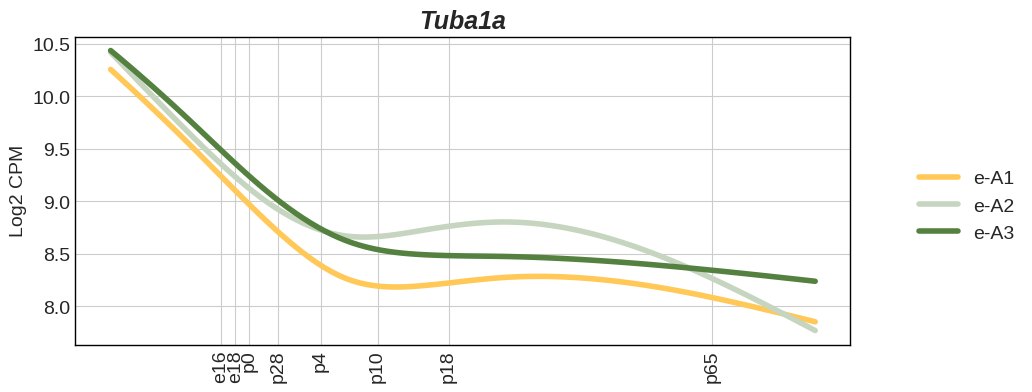

In [16]:
# plot multiple devDEG trends on same plot, clusters should be in a list
plot_trends( clusters=["e-A1", "e-A2", "e-A3"], gene="Tuba1a")

### Can also scale trends 0 to 1

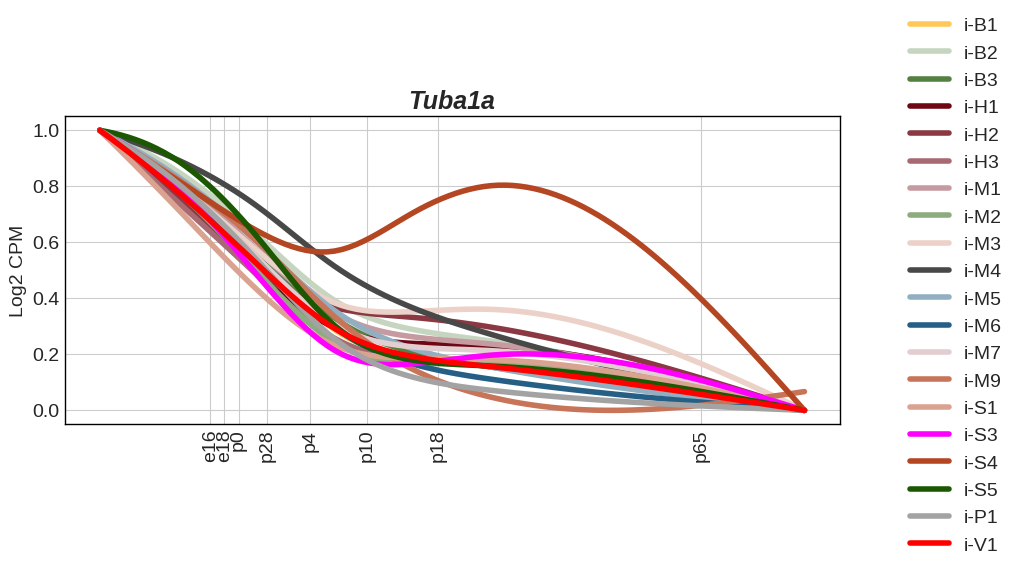

In [17]:
# plot multiple devDEG trends on same plot, clusters should be in a list
# plot_trends( clusters = ["e-A1", "e-A2", "e-A3", 
#                         "e-F1", 
#                         "e-M1", "e-M2", "e-M3", "e-M4",
#                         "e-M5", "e-M8", "e-M9", "e-M10",
#                         "e-P1", "e-P2", "e-P3"],
#            gene = "Tuba1a", 
#            scale=True)
# remove i-S2, i-M8
plot_trends(["i-B1", "i-B2", "i-B3", 
             "i-H1", "i-H2", "i-H3",
             "i-M1", "i-M2", "i-M3",
             "i-M4", "i-M5", "i-M6",
             "i-M7", "i-M9", 
             "i-S1", "i-S3", "i-S4", "i-S5",
             "i-P1", 
             "i-V1"],"Tuba1a", scale = True)